Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [53]:
from random import random, seed
from itertools import product
from itertools import accumulate
from icecream import ic
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import itertools

## TEST Code

In [19]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [55]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Functions

In [54]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    # np.logical_or.reduce(SETS[solution]) is the phenotype
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution: np.ndarray) -> tuple[bool, float]:
    return (valid(solution), -cost(solution))

In [55]:
def single_mutation(solution: np.ndarray, num_set) -> np.ndarray:
    new_solution = solution.copy()
    random_set = rng.integers(0, num_set)
    new_solution[random_set] = not new_solution[random_set]
    return new_solution

def multiple_mutation(solution: np.ndarray, num_set) -> np.ndarray:
    mask = rng.random(num_set) < 0.01  # Only 1% of the elements in the solution array have a chance of being mutated
    new_solution = np.logical_xor(solution, mask)
    return new_solution

def multiple_mutation_strenght(solution: np.ndarray, num_set, strengh: float = 0.3) -> np.ndarray:
    mask = rng.random(num_set) < strengh # Create a mask with probability = strength
    # Ensures that the function always mutates at least one bit
    if not np.any(mask):
        mask[np.random.randint(num_set)] = True
    # Xor with the random solution
    new_solution = np.logical_xor(solution, mask)
    
    return new_solution

def print_set(given_set, num_set, given_fit, name):
    print(f"Final fitness {name}: {given_fit}")
    if num_set <= 100:
        selected_sets = [i for i in range(num_set) if given_set[i] == True]
        print(f"Selected sets: {selected_sets}")
    
def plot_hist(history, plot_best_fit: True, title):
    steps = list(range(len(history)))
    plt.figure(figsize=(8, 4))
    plt.scatter(steps, history, label='Fitness', s=5)
    if plot_best_fit : plt.plot(steps, list(accumulate(history, max)), label='Best fitness', color='red')
    plt.title(title)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid()
    plt.show()
    
def check_solution(solution, name, universe_size, num_sets, density, best_fit_value, best_fit_name):
    print()
    print(name," Parameters:", universe_size, num_sets, density)
    
    best_performance_algorithm = best_fit_value
    best_performance_algorithm_name = best_fit_name
    algo_fitness = fitness(solution)
    if algo_fitness[0] and algo_fitness[1] > best_fit_value:
            best_performance_algorithm = algo_fitness[1]
            best_performance_algorithm_name = name
    
    print_set(solution, num_sets, algo_fitness, name)
    
    return best_performance_algorithm, best_performance_algorithm_name

## Algorithms

In [56]:
ALL_INSTANCES = [
    {"UNIVERSE_SIZE": 100, "NUM_SETS": 10, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 1000, "NUM_SETS": 100, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 10_000, "NUM_SETS": 1_000, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.1},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.3}
]

MAX_STEPS = 10_000

In [57]:
# Greedy approach Version 1, with my not optimal search for best covering set
# Start from a empty solution
# Starting from an empty universe cover, loop till the universe is fully covered.
# Each iteration select the SET that increare the number of elements covered by the given set.
def greedy_solution(uni_size, num_sets):
    universe_solution = np.full(uni_size, False)
    sets_solution = np.full(num_sets, False)
    solution_fitness = fitness(sets_solution)
    history = [float(solution_fitness[1])]
    n_counter = 0
    
    while universe_solution.sum() != uni_size:
        best_covering_values = 0
        best_i = 0
        n_counter += 1
        # Search is O(NUM_SETS)
        for i in range(num_sets):
            aus = np.logical_or(universe_solution, SETS[i])
            covering_values = aus.sum()
            if best_covering_values < covering_values:
                best_covering_values = aus.sum()
                best_i = i
        
        sets_solution[best_i] = True
        universe_solution = np.logical_or(universe_solution, SETS[best_i])
        f = fitness(sets_solution)
        history.append(float(f[1]))
    
    return sets_solution, n_counter, history

In [58]:
# First solution: RMHC with single mutation
def RMHC_SM(initial_solution, num_set):
    solution = initial_solution
    solution_fitness = fitness(solution)
    history = [solution_fitness[1]]
    print(f"Initial fitness: {solution_fitness}")

    for steps in range (MAX_STEPS):
        new_solution = single_mutation(solution, num_set)
        f = fitness(new_solution)
        history.append(f[1])
        
        if f > solution_fitness:
            solution = new_solution
            solution_fitness = f
            
    return solution, history

In [59]:
# Second solution: RMHC with multiple mutation
def RMHC_MM(initial_solution, num_set):
    solution = initial_solution
    solution_fitness = fitness(solution)
    history = [solution_fitness[1]]
    print(f"Initial fitness: {solution_fitness}")

    for steps in range (MAX_STEPS):
        new_solution = multiple_mutation(solution, num_set)
        f = fitness(new_solution)
        history.append(f[1])
        
        if f > solution_fitness:
            solution = new_solution
            solution_fitness = f
    
    return solution, history      
    

In [60]:
# Simulated Annealing 
def simulated_annealing(initial_solution, num_set, initial_temp=300, cooling_rate=0.99):
    solution = initial_solution
    solution_fitness = fitness(solution)
    
    temp = initial_temp
    history = [solution_fitness[1]]
    print(f"Initial fitness: {solution_fitness}")
    
    for _ in range(MAX_STEPS):
        # Generate a new solution
        new_solution = single_mutation(solution, num_set)
        
        # Skip invalid solutions
        if not valid(new_solution):
            continue
        
        new_fitness = fitness(new_solution)

        # Record the current fitness in the history
        history.append(new_fitness[1])
        
        # Calculate the fitness difference (delta_fitness)
        delta_fitness = new_fitness[1] - solution_fitness[1]
        
        # Acceptance criterion: accept if the new solution has better fitness, or probabilistically if worse
        if delta_fitness > 0 or random() < np.exp(delta_fitness / temp):
            solution = new_solution
            solution_fitness = new_fitness
        
        # Cool down the temperature
        temp *= cooling_rate
        
        # Terminate if the temperature is too low
        if temp < 1e-5:
            break
    
    return solution, history

In [61]:
# Tabu Search 
def tabu_search(initial_solution, num_set,tabu_size=50):
    
    solution = initial_solution
    solution_fitness = fitness(solution)
    
    best_solution = solution
    best_fitness = solution_fitness
    
    # Tabu list to store recent solutions or moves
    tabu_list = []
    tabu_list.append(solution.copy().tolist())  
    
    history = [solution_fitness[1]] 

    for _ in range(MAX_STEPS):
        # Generate 10 neighbor solutions
        neighborhood = [multiple_mutation(solution, num_set) for _ in range(10)]  
        
        # Filter out solutions that are in the tabu list and check if they are valid
        valid_neighbors = [n for n in neighborhood if valid(n) and n.tolist() not in tabu_list]
        
        if not valid_neighbors:
            # If no valid neighbors (that are not in the tabu list), skip to next iteration
            continue
        
        # Evaluate fitness of each valid neighbor
        neighbor_fitness = [fitness(n) for n in valid_neighbors]
        
        # Select the best neighbor solution (maximize fitness, i.e., minimize cost)
        best_neighbor_index = np.argmax([f[1] for f in neighbor_fitness])
        best_neighbor = valid_neighbors[best_neighbor_index]
        best_neighbor_fitness = neighbor_fitness[best_neighbor_index]
        
        # Update the current solution
        solution = best_neighbor
        solution_fitness = best_neighbor_fitness
        
        # Add the new solution to the tabu list
        tabu_list.append(solution.copy().tolist())
        tabu_list = tabu_list[-tabu_size:]
        
        # Update the global best solution if the current one is better
        if solution_fitness[1] > best_fitness[1]:
            best_solution = solution
            best_fitness = solution_fitness
        
        # Track fitness history
        history.append(solution_fitness[1])
        
    return best_solution, history

In [62]:
def one_out_5(initial_solution, num_set):
    # 1 out of 5 versione
    # Starting from the gredy solution try to optimaze it
    BUFFER_SIZE = 5

    # IF start with a random solution the execution time is too much
    #solution = rng.random(num_set) < 1
    #solution, n_search = greedy_solution()
    solution = initial_solution
    solution_fitness = fitness(solution)
    history = [float(solution_fitness[1])]
    ic(fitness(solution))
    strength = 0.5
    buffer = list()

    for steps in range(10_000):
        new_solution = multiple_mutation_strenght(solution, num_set, strength)
        f = fitness(new_solution)
        history.append(float(f[1]))
        buffer.append(f > solution_fitness)
        buffer = buffer[-BUFFER_SIZE:]
        
        if sum(buffer) > 1:
            strength *= 1.2
        elif sum(buffer) == 0:
            strength /= 1.2
        
        if f > solution_fitness:
            solution = new_solution
            solution_fitness = f

    return solution, history

# MAIN
This code find the best algorithm for all istances.
In this case the initial solution will be a random one, exept for the greedy solution that will start from an empty solution


Greedy Solution Parameters: 100 10 0.2
Number of iterations:  10
Final fitness Greedy Solution: (True, -298.8350790306573)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Dumb Solution 100%  Parameters: 100 10 0.2
Final fitness Dumb Solution 100%: (True, -298.8350790306573)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Dumb Solution 50%  Parameters: 100 10 0.2
Final fitness Dumb Solution 50%: (False, -144.14194964932736)
Selected sets: [2, 5, 6, 8, 9]

Dumb Solution 20%  Parameters: 100 10 0.2
Final fitness Dumb Solution 20%: (False, -64.44889236410083)
Selected sets: [0, 3]
Initial fitness: (False, -122.90375790546588)

Simulated_annealing  Parameters: 100 10 0.2
Final fitness Simulated_annealing: (False, -122.90375790546588)
Selected sets: [1, 2, 8, 9]


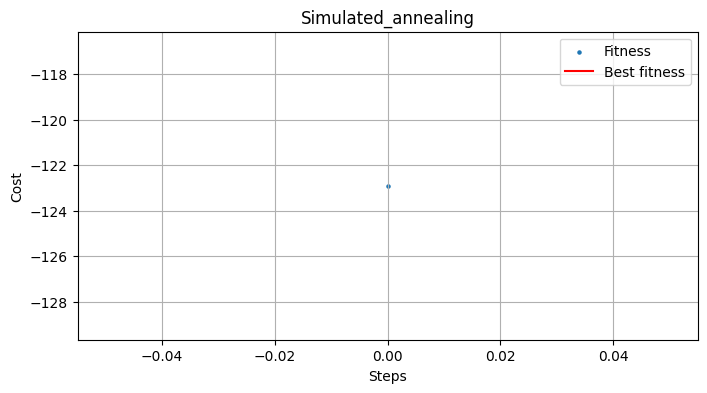

ic| fitness(solution): (False, -122.90375790546588)



1out of 5  Parameters: 100 10 0.2
Final fitness 1out of 5: (False, -0.0)
Selected sets: []


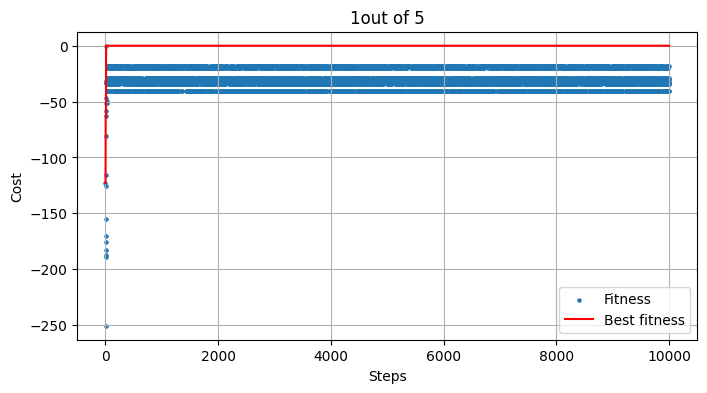

Initial fitness: (False, -122.90375790546588)

Vanilla Hill Climber  Parameters: 100 10 0.2
Final fitness Vanilla Hill Climber: (False, -0.0)
Selected sets: []


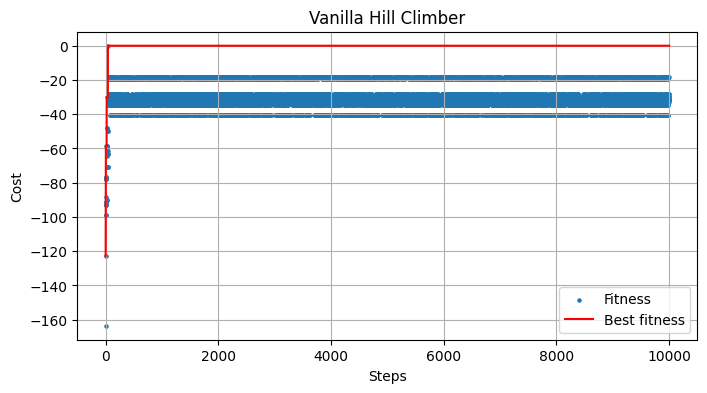

Initial fitness: (False, -122.90375790546588)

Hill Climber MULTI  Parameters: 100 10 0.2
Final fitness Hill Climber MULTI: (False, -0.0)
Selected sets: []


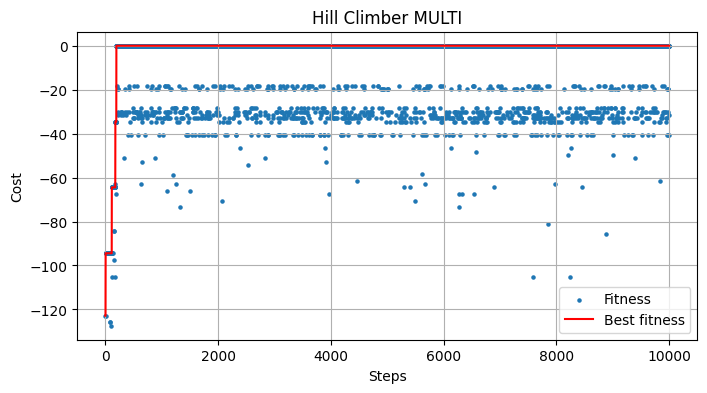


TABU SEARCH  Parameters: 100 10 0.2
Final fitness TABU SEARCH: (False, -122.90375790546588)
Selected sets: [1, 2, 8, 9]


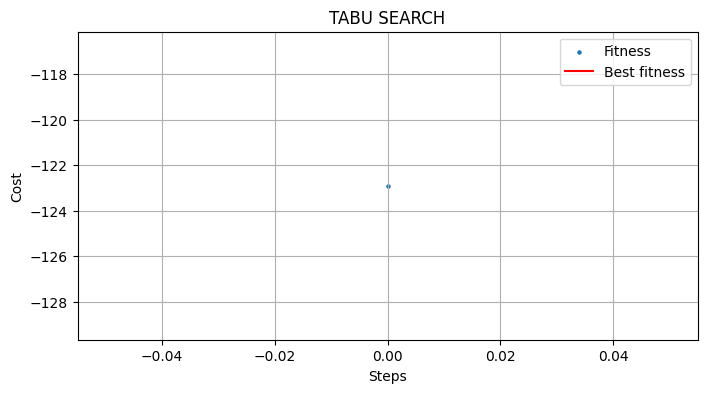


Greedy Solution Parameters: 1000 100 0.2
Number of iterations:  16
Final fitness Greedy Solution: (True, -5684.777231272481)
Selected sets: [0, 4, 15, 20, 27, 39, 41, 43, 52, 57, 67, 71, 76, 79, 91, 99]

Dumb Solution 100%  Parameters: 1000 100 0.2
Final fitness Dumb Solution 100%: (True, -34073.91736430717)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Dumb Solution 50%  Parameters: 1000 100 0.2
Final fitness Dumb Solution 50%: (True, -16194.242266743486)
Selected sets: [1, 2, 14, 15, 16, 17, 20, 23, 24, 25, 26, 29, 30, 31, 34, 35, 37, 40, 41, 44, 46, 49, 50, 51, 52, 54, 55, 59, 60, 66, 67, 68, 69, 72, 73, 74, 77, 78, 79, 83, 84,

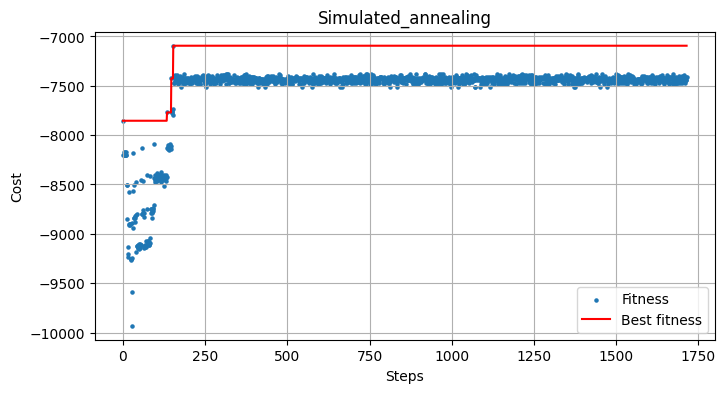

ic| fitness(solution): (False, -7854.341878768545)



1out of 5  Parameters: 1000 100 0.2
Final fitness 1out of 5: (True, -7045.846495318095)
Selected sets: [7, 18, 22, 23, 24, 29, 36, 43, 45, 46, 47, 51, 56, 57, 68, 69, 74, 79, 80, 85, 92]


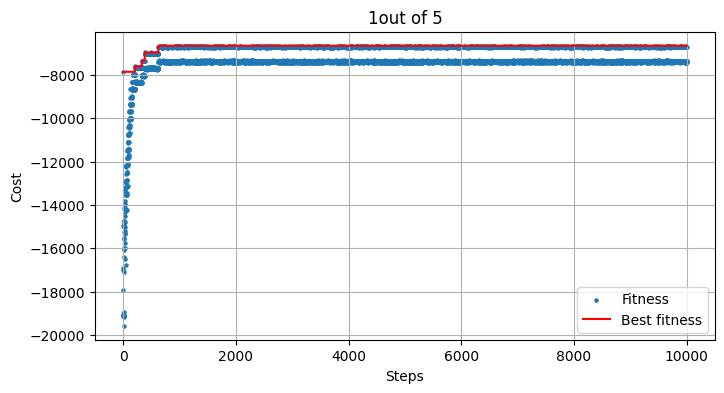

Initial fitness: (False, -7854.341878768545)

Vanilla Hill Climber  Parameters: 1000 100 0.2
Final fitness Vanilla Hill Climber: (False, -0.0)
Selected sets: []


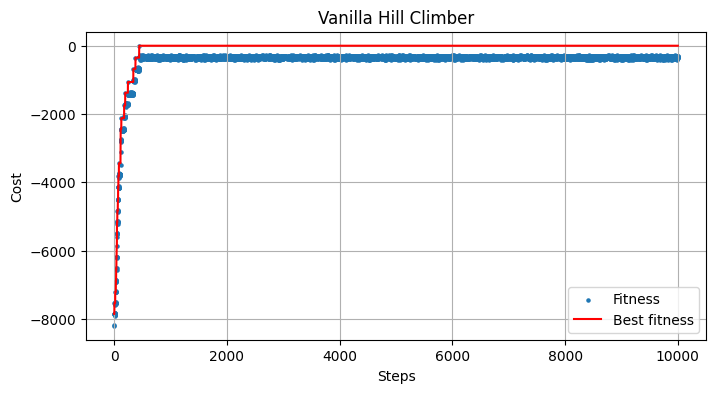

Initial fitness: (False, -7854.341878768545)

Hill Climber MULTI  Parameters: 1000 100 0.2
Final fitness Hill Climber MULTI: (True, -6269.593738087452)
Selected sets: [1, 2, 3, 6, 7, 12, 15, 20, 38, 47, 52, 60, 75, 81, 85, 87, 88, 92, 94]


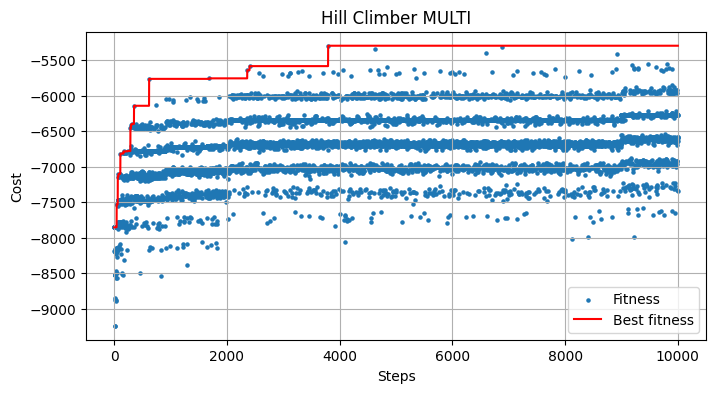


TABU SEARCH  Parameters: 1000 100 0.2
Final fitness TABU SEARCH: (True, -6891.408968604678)
Selected sets: [1, 8, 10, 19, 24, 28, 30, 31, 38, 43, 44, 52, 55, 61, 78, 80, 81, 87, 92, 94, 98]


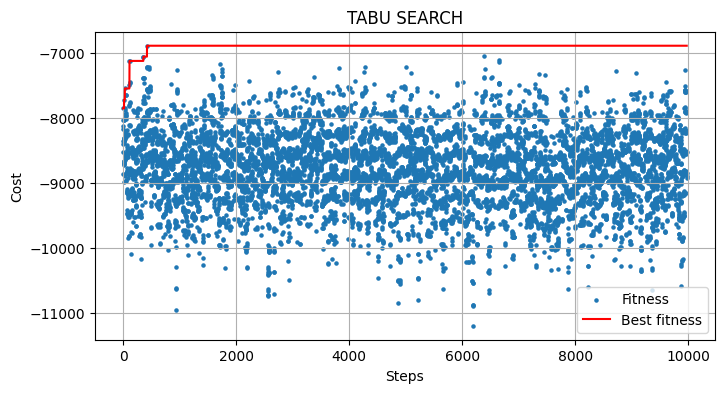


Greedy Solution Parameters: 10000 1000 0.2
Number of iterations:  23
Final fitness Greedy Solution: (True, -99867.19747592443)

Dumb Solution 100%  Parameters: 10000 1000 0.2
Final fitness Dumb Solution 100%: (True, -4278320.517515982)

Dumb Solution 50%  Parameters: 10000 1000 0.2
Final fitness Dumb Solution 50%: (True, -2140474.982206951)

Dumb Solution 20%  Parameters: 10000 1000 0.2
Final fitness Dumb Solution 20%: (True, -823228.2179283595)
Initial fitness: (True, -1249482.1207265346)

Simulated_annealing  Parameters: 10000 1000 0.2
Final fitness Simulated_annealing: (True, -251137.3408272087)


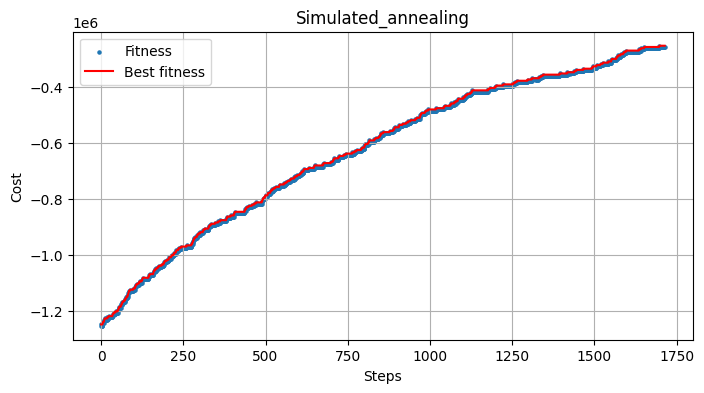

ic| fitness(solution): (True, -1249482.1207265346)



1out of 5  Parameters: 10000 1000 0.2
Final fitness 1out of 5: (True, -128315.92093405072)


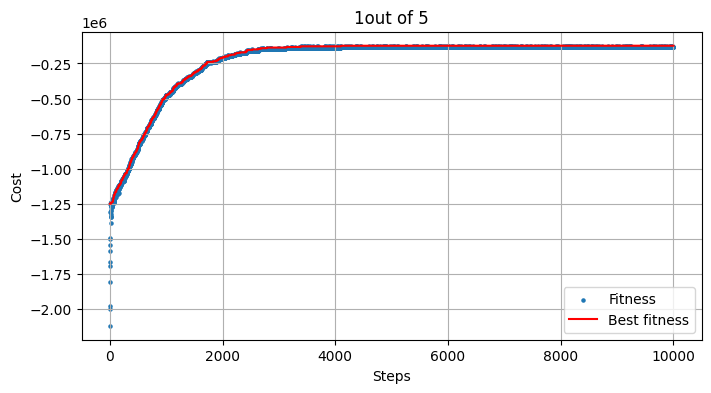

Initial fitness: (True, -1249482.1207265346)

Vanilla Hill Climber  Parameters: 10000 1000 0.2
Final fitness Vanilla Hill Climber: (True, -123720.13435394621)


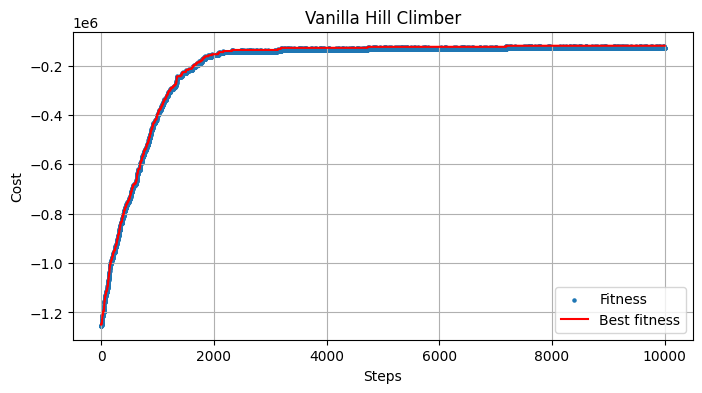

Initial fitness: (True, -1249482.1207265346)

Hill Climber MULTI  Parameters: 10000 1000 0.2
Final fitness Hill Climber MULTI: (True, -531108.1803573056)


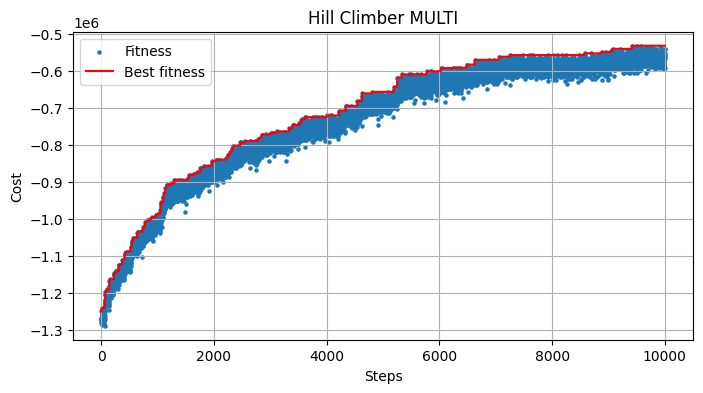


TABU SEARCH  Parameters: 10000 1000 0.2
Final fitness TABU SEARCH: (True, -1019568.8164336913)


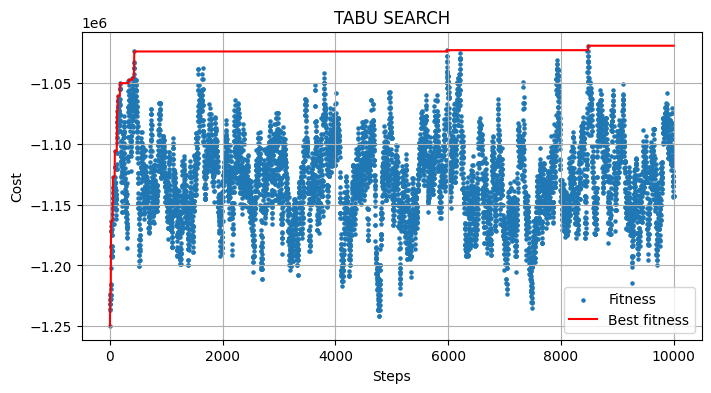


Greedy Solution Parameters: 100000 10000 0.1
Number of iterations:  60
Final fitness Greedy Solution: (True, -1519082.9373986344)

Dumb Solution 100%  Parameters: 100000 10000 0.1
Final fitness Dumb Solution 100%: (True, -251236596.17792144)

Dumb Solution 50%  Parameters: 100000 10000 0.1
Final fitness Dumb Solution 50%: (True, -124559277.5534335)

Dumb Solution 20%  Parameters: 100000 10000 0.1
Final fitness Dumb Solution 20%: (True, -49475402.16073626)

Greedy Solution Parameters: 100000 10000 0.2
Number of iterations:  32
Final fitness Greedy Solution: (True, -1732065.2140000514)

Dumb Solution 100%  Parameters: 100000 10000 0.2
Final fitness Dumb Solution 100%: (True, -538434211.0258479)

Dumb Solution 50%  Parameters: 100000 10000 0.2
Final fitness Dumb Solution 50%: (True, -268518357.02792233)

Dumb Solution 20%  Parameters: 100000 10000 0.2
Final fitness Dumb Solution 20%: (True, -108603856.1481464)

Greedy Solution Parameters: 100000 10000 0.3
Number of iterations:  21
Final 

In [63]:
# All results for the greedy solution for all Istances
# Executable it takes about 3/4min
best_results = []

for conf in ALL_INSTANCES:
    rng = np.random.Generator(np.random.PCG64([conf["UNIVERSE_SIZE"], conf["NUM_SETS"], int(10_000 * conf["DENSITY"])]))
    
    SETS = np.random.random((conf["NUM_SETS"], conf["UNIVERSE_SIZE"])) < conf["DENSITY"]
    for s in range(conf["UNIVERSE_SIZE"]):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(conf["NUM_SETS"]), s] = True
    COSTS = np.power(SETS.sum(axis=1), 1.1)
    
    print()
    print("Greedy Solution Parameters:", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"])
    
    solution, n_search, history = greedy_solution(conf["UNIVERSE_SIZE"], conf["NUM_SETS"])
    algo_fitness = fitness(solution)
    best_performance_algorithm = algo_fitness[1]
    best_performance_algorithm_name = "Greedy Solution"
    
    print("Number of iterations: ", n_search)
    print_set(solution, conf["NUM_SETS"], algo_fitness, "Greedy Solution")
    # Why it seems to be linear??
    #plot_hist(history, plot_best_fit=False, "Greedy Solution")
    
    ### Dumb Solution ###
    
    # A dumb solution of "all" sets
    solution = np.full(conf["NUM_SETS"], True)
    best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Dumb Solution 100%", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
            
    # Dumb solution 2
    # A random solution with random 50% of the sets
    solution = rng.random(conf["NUM_SETS"]) < .5
    best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Dumb Solution 50%", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
            
    # Dumb solution 3
    # A random solution with random 2% of the sets
    solution = rng.random(conf["NUM_SETS"]) < .2
    best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Dumb Solution 20%", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
    
    ### END ###
    
    # For universe >= 100_000 I assume the greedy solution is the best, even if the other algorith could obtain better results it's not worth because it takes too much time compared to 25/30s of the greedy solution.
    if conf["UNIVERSE_SIZE"] != 100_000:
        initial_solution = rng.random(conf["NUM_SETS"]) < 0.3 # Initialize a random solution
        ### SIMULATED ANNEALING ###
        
        solution, history = simulated_annealing(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Simulated_annealing", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "Simulated_annealing")
        
        ### END ###
        
        ### 1 OUT OF 5 ###
        
        solution, history = one_out_5(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "1out of 5", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "1out of 5")
        
        ### END ###
        
        ### Vanilla Hill Climber ###

        solution, history = RMHC_SM(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Vanilla Hill Climber", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "Vanilla Hill Climber")
        
        ### END ###
        ### Hill Climber MULTI ###
        
        solution, history = RMHC_MM(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Hill Climber MULTI", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "Hill Climber MULTI")

        ### END ###
        
        ### TABU SEARCH ###

        solution, history = tabu_search(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "TABU SEARCH", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "TABU SEARCH")

        ### END ###
    best_results.append({"UNIVERSE_SIZE": conf["UNIVERSE_SIZE"], "NUM_SETS": conf["NUM_SETS"], "DENSITY": conf["DENSITY"], "name": best_performance_algorithm_name, "best_value": best_performance_algorithm})
    
    
for result in best_results:
    print('*'*50)    
    print("Best performer algorith for {", result["UNIVERSE_SIZE"], result["NUM_SETS"], result["DENSITY"],"} is: ", result["name"])    
    print("With the following results: ", result["best_value"])
    print('*'*50)  
    

# INITIAL SOLUTION = GREEDY SOLUTION
let's see if the other algorith can do better starting from a reasonable solution


Greedy Solution Parameters: 100 10 0.2
Number of iterations:  10
Final fitness Greedy Solution: (True, -274.641401336523)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Dumb Solution 100%  Parameters: 100 10 0.2
Final fitness Dumb Solution 100%: (True, -274.641401336523)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Dumb Solution 50%  Parameters: 100 10 0.2
Final fitness Dumb Solution 50%: (False, -130.6506592163442)
Selected sets: [2, 5, 6, 8, 9]

Dumb Solution 20%  Parameters: 100 10 0.2
Final fitness Dumb Solution 20%: (False, -59.94380515707232)
Selected sets: [0, 3]
Initial fitness: (True, -274.641401336523)

Simulated_annealing  Parameters: 100 10 0.2
Final fitness Simulated_annealing: (True, -274.641401336523)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


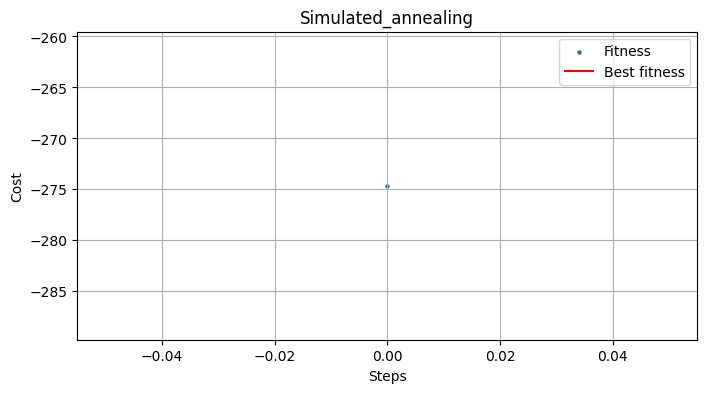

ic| fitness(solution): (True, -274.641401336523)



1out of 5  Parameters: 100 10 0.2
Final fitness 1out of 5: (True, -274.641401336523)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


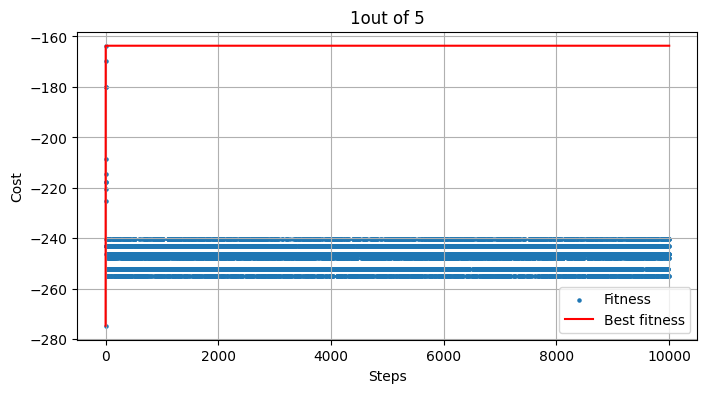

Initial fitness: (True, -274.641401336523)

Vanilla Hill Climber  Parameters: 100 10 0.2
Final fitness Vanilla Hill Climber: (True, -274.641401336523)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


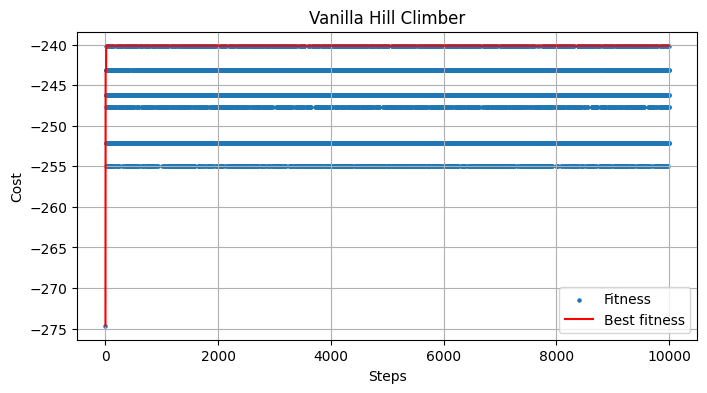

Initial fitness: (True, -274.641401336523)

Hill Climber MULTI  Parameters: 100 10 0.2
Final fitness Hill Climber MULTI: (True, -274.641401336523)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


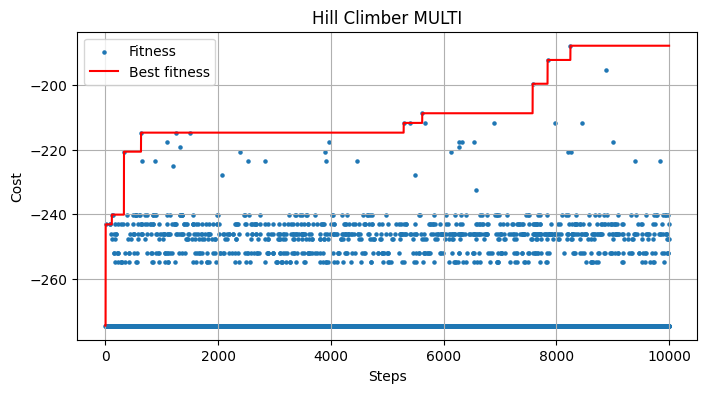


TABU SEARCH  Parameters: 100 10 0.2
Final fitness TABU SEARCH: (True, -274.641401336523)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


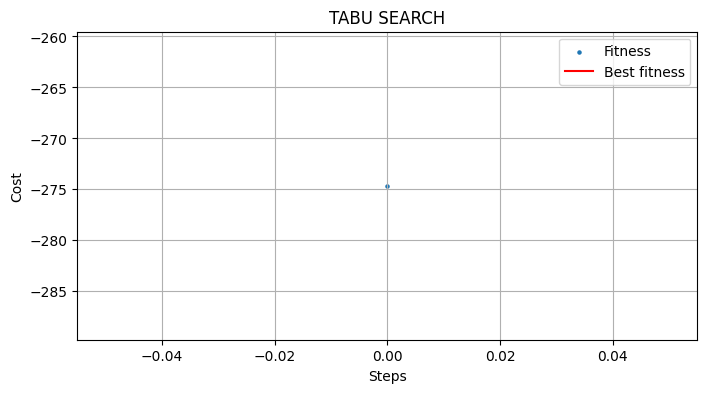


Greedy Solution Parameters: 1000 100 0.2
Number of iterations:  18
Final fitness Greedy Solution: (True, -6384.2351537095765)
Selected sets: [3, 5, 7, 9, 11, 12, 14, 15, 16, 21, 25, 34, 48, 50, 60, 74, 77, 95]

Dumb Solution 100%  Parameters: 1000 100 0.2
Final fitness Dumb Solution 100%: (True, -34152.04655423074)
Selected sets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Dumb Solution 50%  Parameters: 1000 100 0.2
Final fitness Dumb Solution 50%: (True, -16108.391933840967)
Selected sets: [1, 2, 14, 15, 16, 17, 20, 23, 24, 25, 26, 29, 30, 31, 34, 35, 37, 40, 41, 44, 46, 49, 50, 51, 52, 54, 55, 59, 60, 66, 67, 68, 69, 72, 73, 74, 77, 78, 79, 

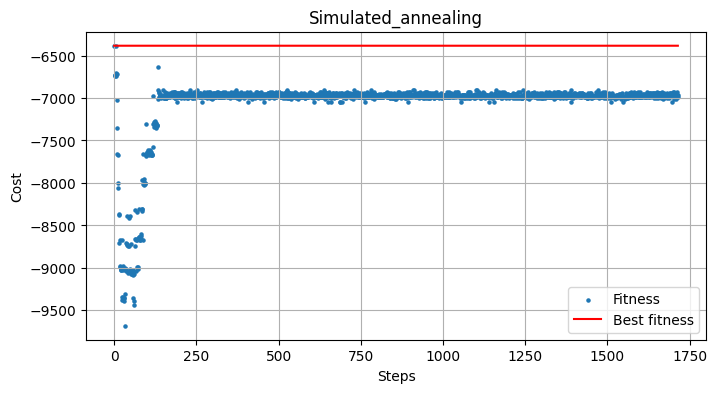

ic| fitness(solution): (True, -6384.2351537095765)



1out of 5  Parameters: 1000 100 0.2
Final fitness 1out of 5: (True, -6384.2351537095765)
Selected sets: [3, 5, 7, 9, 11, 12, 14, 15, 16, 21, 25, 34, 48, 50, 60, 74, 77, 95]


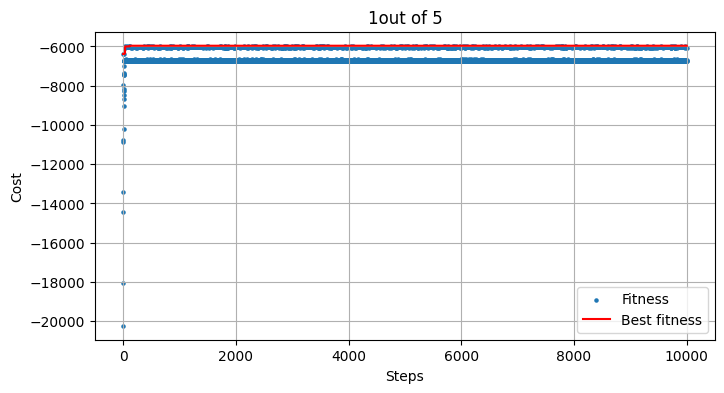

Initial fitness: (True, -6384.2351537095765)

Vanilla Hill Climber  Parameters: 1000 100 0.2
Final fitness Vanilla Hill Climber: (True, -6384.2351537095765)
Selected sets: [3, 5, 7, 9, 11, 12, 14, 15, 16, 21, 25, 34, 48, 50, 60, 74, 77, 95]


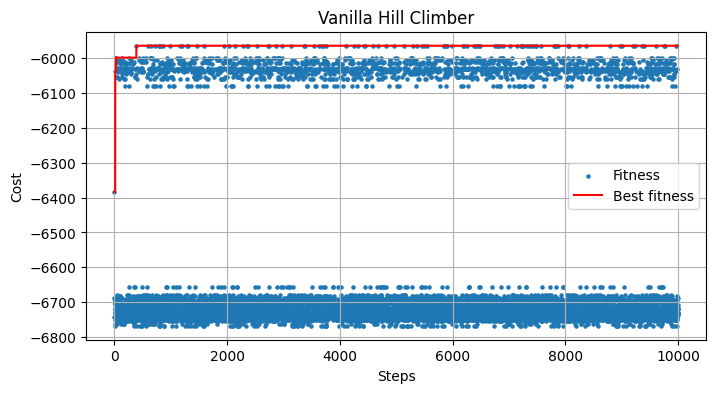

Initial fitness: (True, -6384.2351537095765)

Hill Climber MULTI  Parameters: 1000 100 0.2
Final fitness Hill Climber MULTI: (True, -5913.5901021834625)
Selected sets: [7, 9, 15, 16, 21, 25, 34, 37, 48, 50, 60, 66, 74, 76, 77, 87, 95]


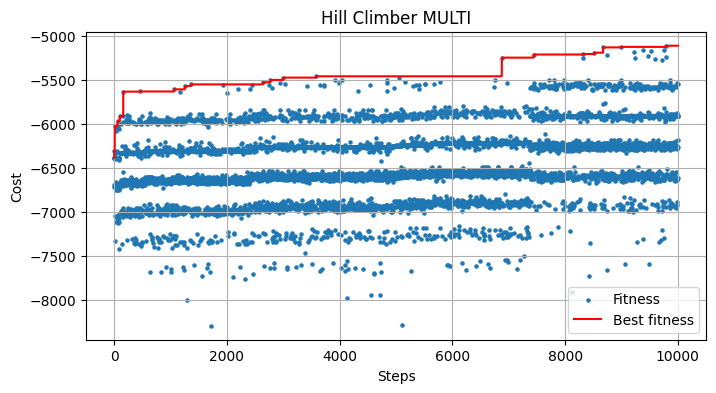


TABU SEARCH  Parameters: 1000 100 0.2
Final fitness TABU SEARCH: (True, -6384.2351537095765)
Selected sets: [3, 5, 7, 9, 11, 12, 14, 15, 16, 21, 25, 34, 48, 50, 60, 74, 77, 95]


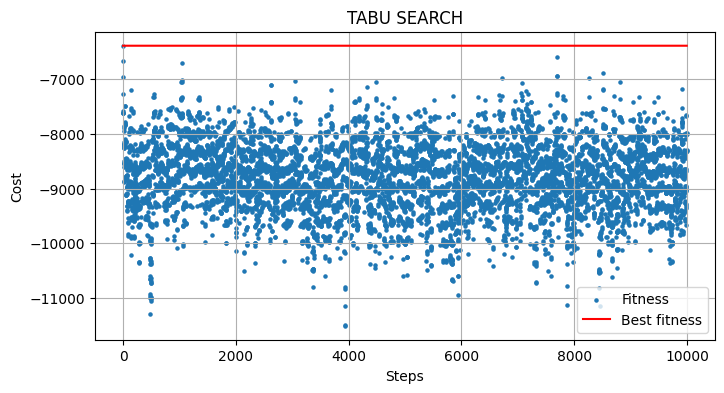


Greedy Solution Parameters: 10000 1000 0.2
Number of iterations:  23
Final fitness Greedy Solution: (True, -100739.45457312933)

Dumb Solution 100%  Parameters: 10000 1000 0.2
Final fitness Dumb Solution 100%: (True, -4274285.062306805)

Dumb Solution 50%  Parameters: 10000 1000 0.2
Final fitness Dumb Solution 50%: (True, -2136367.6338828485)

Dumb Solution 20%  Parameters: 10000 1000 0.2
Final fitness Dumb Solution 20%: (True, -818591.4430140343)
Initial fitness: (True, -100739.45457312933)

Simulated_annealing  Parameters: 10000 1000 0.2
Final fitness Simulated_annealing: (True, -100739.45457312933)


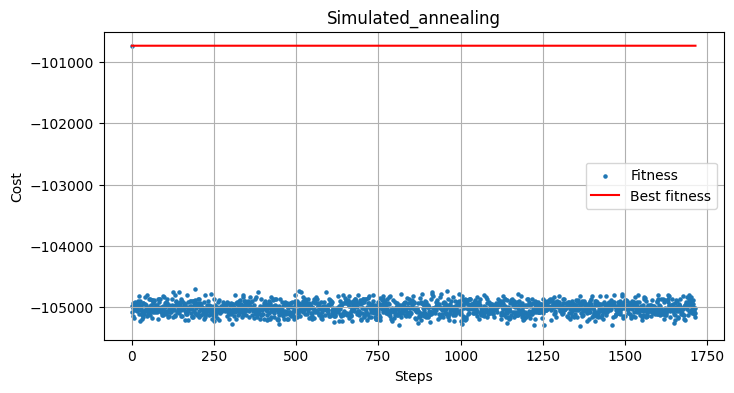

ic| fitness(solution): (True, -100739.45457312933)



1out of 5  Parameters: 10000 1000 0.2
Final fitness 1out of 5: (True, -100739.45457312933)


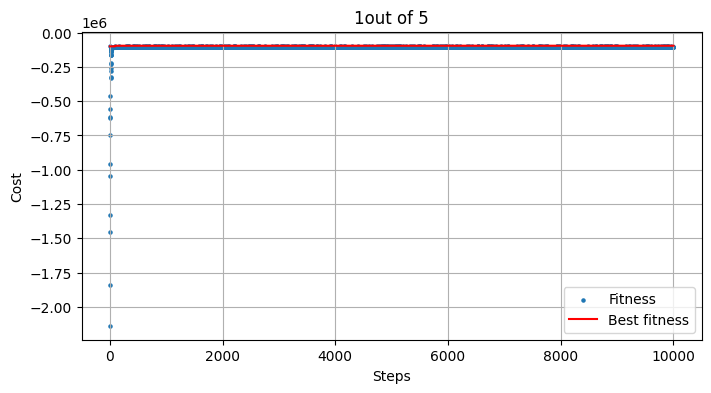

Initial fitness: (True, -100739.45457312933)

Vanilla Hill Climber  Parameters: 10000 1000 0.2
Final fitness Vanilla Hill Climber: (True, -100739.45457312933)


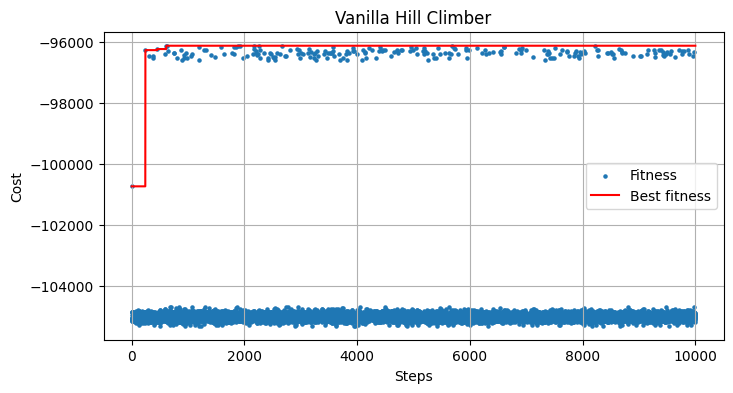

Initial fitness: (True, -100739.45457312933)

Hill Climber MULTI  Parameters: 10000 1000 0.2
Final fitness Hill Climber MULTI: (True, -100739.45457312933)


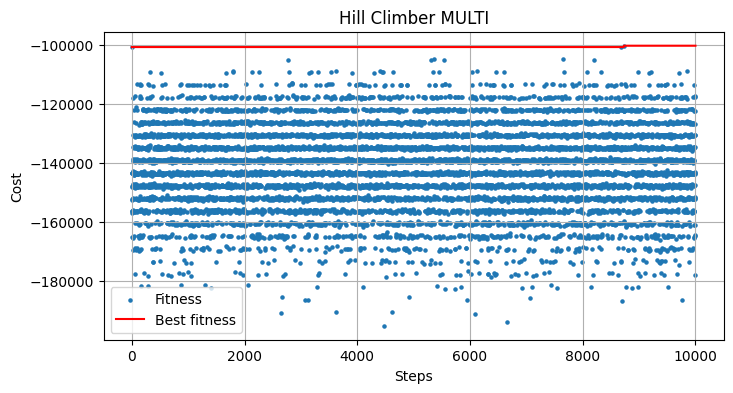


TABU SEARCH  Parameters: 10000 1000 0.2
Final fitness TABU SEARCH: (True, -100739.45457312933)


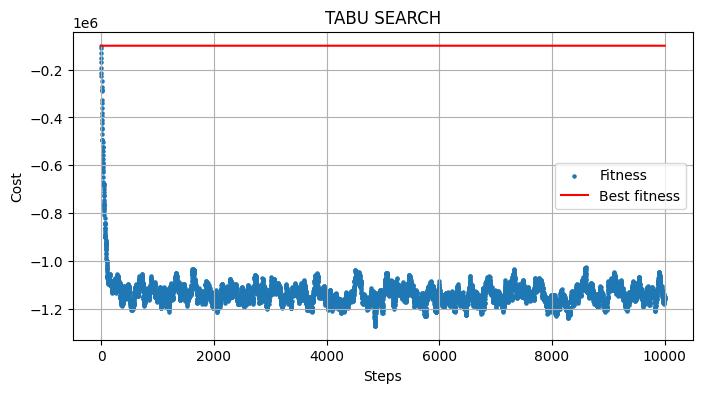


Greedy Solution Parameters: 100000 10000 0.1
Number of iterations:  60
Final fitness Greedy Solution: (True, -1520742.5086611921)

Dumb Solution 100%  Parameters: 100000 10000 0.1
Final fitness Dumb Solution 100%: (True, -251203034.68779847)

Dumb Solution 50%  Parameters: 100000 10000 0.1
Final fitness Dumb Solution 50%: (True, -124524920.19234648)

Dumb Solution 20%  Parameters: 100000 10000 0.1
Final fitness Dumb Solution 20%: (True, -49462605.21424304)

Greedy Solution Parameters: 100000 10000 0.2
Number of iterations:  32
Final fitness Greedy Solution: (True, -1731762.284684427)

Dumb Solution 100%  Parameters: 100000 10000 0.2
Final fitness Dumb Solution 100%: (True, -538430210.4500179)

Dumb Solution 50%  Parameters: 100000 10000 0.2
Final fitness Dumb Solution 50%: (True, -268493304.18337715)

Dumb Solution 20%  Parameters: 100000 10000 0.2
Final fitness Dumb Solution 20%: (True, -108596302.25419496)

Greedy Solution Parameters: 100000 10000 0.3
Number of iterations:  21
Final

In [64]:
# Same as before BUT the initial solution for each algorith will be the greedy solution!
# All results for the greedy solution for all Istances
# Executable it takes about 2 min
# And the best solution is still the greedy solution
best_results = []

for conf in ALL_INSTANCES:
    rng = np.random.Generator(np.random.PCG64([conf["UNIVERSE_SIZE"], conf["NUM_SETS"], int(10_000 * conf["DENSITY"])]))
    
    SETS = np.random.random((conf["NUM_SETS"], conf["UNIVERSE_SIZE"])) < conf["DENSITY"]
    for s in range(conf["UNIVERSE_SIZE"]):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(conf["NUM_SETS"]), s] = True
    COSTS = np.power(SETS.sum(axis=1), 1.1)
    
    print()
    print("Greedy Solution Parameters:", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"])
    
    solution, n_search, history = greedy_solution(conf["UNIVERSE_SIZE"], conf["NUM_SETS"])
    initial_solution = solution # Initial solution for all the others!
    algo_fitness = fitness(solution)
    best_performance_algorithm = algo_fitness[1]
    best_performance_algorithm_name = "Greedy Solution"
    
    print("Number of iterations: ", n_search)
    print_set(solution, conf["NUM_SETS"], algo_fitness, "Greedy Solution")
    # Why it seems to be linear??
    #plot_hist(history, plot_best_fit=False, "Greedy Solution")
    
    ### Dumb Solution ###
    
    # A dumb solution of "all" sets
    solution = np.full(conf["NUM_SETS"], True)
    best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Dumb Solution 100%", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
            
    # Dumb solution 2
    # A random solution with random 50% of the sets
    solution = rng.random(conf["NUM_SETS"]) < .5
    best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Dumb Solution 50%", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
            
    # Dumb solution 3
    # A random solution with random 2% of the sets
    solution = rng.random(conf["NUM_SETS"]) < .2
    best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Dumb Solution 20%", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
    
    ### END ###
    
    # For universe >= 100_000 I assume the greedy solution is the best, even if the other algorith could obtain better results it's not worth because it takes too much time compared to 25/30s of the greedy solution.
    if conf["UNIVERSE_SIZE"] != 100_000:
        ### SIMULATED ANNEALING ###
        
        solution, history = simulated_annealing(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Simulated_annealing", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "Simulated_annealing")
        
        ### END ###
        
        ### 1 OUT OF 5 ###
        
        solution, history = one_out_5(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "1out of 5", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "1out of 5")
        
        ### END ###
        
        ### Vanilla Hill Climber ###

        solution, history = RMHC_SM(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Vanilla Hill Climber", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "Vanilla Hill Climber")
        
        ### END ###
        ### Hill Climber MULTI ###
        
        solution, history = RMHC_MM(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "Hill Climber MULTI", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "Hill Climber MULTI")

        ### END ###
        
        ### TABU SEARCH ###

        solution, history = tabu_search(initial_solution, conf["NUM_SETS"])
        best_performance_algorithm, best_performance_algorithm_name = check_solution(solution, "TABU SEARCH", conf["UNIVERSE_SIZE"], conf["NUM_SETS"], conf["DENSITY"], best_performance_algorithm, best_performance_algorithm_name)
        plot_hist(history, True, "TABU SEARCH")

        ### END ###
    
    best_results.append({"UNIVERSE_SIZE": conf["UNIVERSE_SIZE"], "NUM_SETS": conf["NUM_SETS"], "DENSITY": conf["DENSITY"], "name": best_performance_algorithm_name, "best_value": best_performance_algorithm})
    
    
for result in best_results:
    print('*'*50)    
    print("Best performer algorith for {", result["UNIVERSE_SIZE"], result["NUM_SETS"], result["DENSITY"],"} is: ", result["name"])    
    print("With the following results: ", result["best_value"])
    print('*'*50)  
    